In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from tqdm import tqdm
import numpy as np
from scipy.stats import spearmanr,kendalltau,permutation_test,kstest,bernoulli,poisson,zscore
import matplotlib as mpl
import matplotlib.pyplot as plt

import burst_func as bf
import plot_func as pf

# Model Thalamic Bursts at Same Retinotopic Location

Plan: consider four ON-center and four OFF-center LGN cells whose RFs are at the same retinopic location. Devise a method of modeling bursts such that spike trains have pairwise Pearson corr coeff of 0.485 for same-center-type and 0.216 for opposite-center-type.

We'll model bursts as having (potentialy generalized) Gaussian rate vs time curves. They tend to be synchronous and have the same statistics, but we can vary spike count correlations.

Spike counts will be modeled as a vector of Poisson random variables, and will be generated with a given vector of marginal expectations and a matrix of Pearson corr coeffs.

## Investigate Feasible Correlated Binary or Poisson Random Variable Parameter Space

For bivariate Bernoulli random variables, the corr coeff $\rho$ is not free over $[-1,1]$ and must obey the bounds $\text{max}\left(-\sqrt{\frac{1-p_1}{p_1}\frac{1-p_2}{p_2}},-\sqrt{\frac{p_1}{1-p_1}\frac{p_2}{1-p_2}}\right) \le \rho \le \text{min}\left(\sqrt{\frac{(1-p_1)/p_1}{(1-p_2)/p_2}},\sqrt{\frac{(1-p_2)/p_2}{(1-p_1)/p_1}}\right)$. For bivariate Poisson random variables, the corr coeff $\rho$ is also not free over $[-1,1]$, with bounds $\text{corr}\left[F_{\lambda_1}^{-1}(U) F_{\lambda_2}^{-1}(1-U)\right] \le \rho \le \text{corr}\left[F_{\lambda_1}^{-1}(U) F_{\lambda_2}^{-1}(U)\right]$ where $F_\lambda(x)$ is the cumulative distribution function of the Poisson distribution with expectation $\lambda$ and $U$ is a standard uniform random variable.

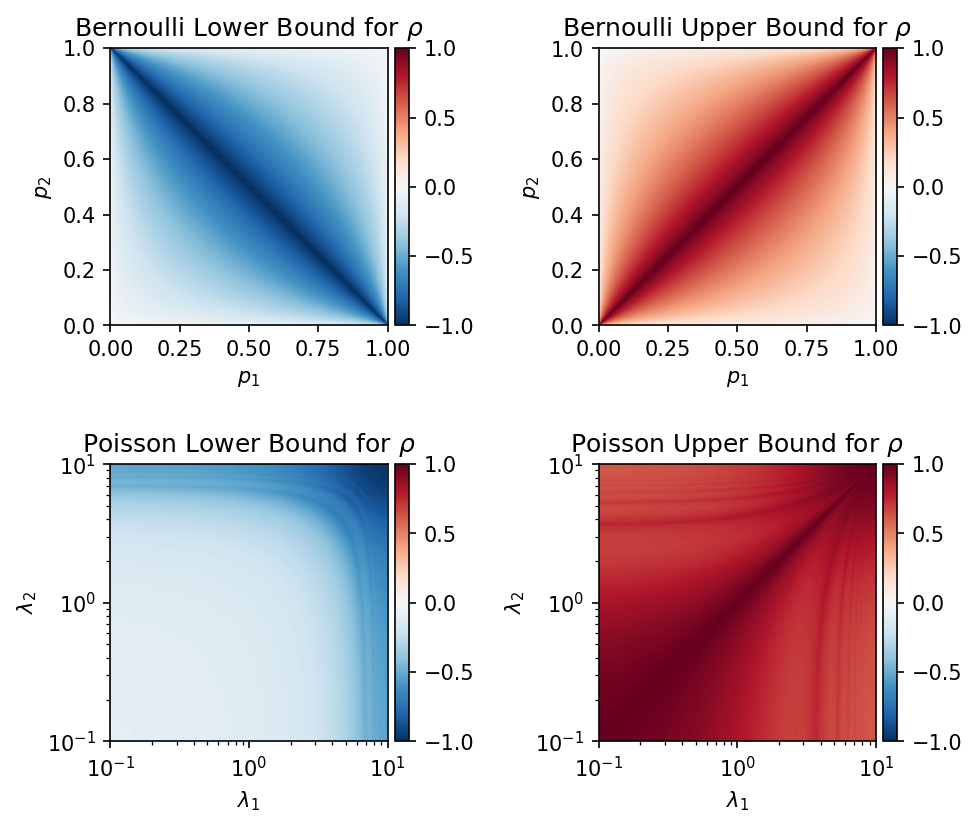

In [3]:
reload(bf)

ps = np.linspace(0,1,1001)[1:-1]

lo_bnd,up_bnd = bf.bin_corr_bnds(ps)

fig,axs = plt.subplots(2,2,figsize=(7,6),dpi=150)
fig.subplots_adjust(hspace=0.5,wspace=0.5)

pf.imshowbar(fig,axs[0,0],lo_bnd,hide_ticks=False,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[0,1,0,1])
pf.imshowbar(fig,axs[0,1],up_bnd,hide_ticks=False,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[0,1,0,1])

axs[0,0].set_title(r'Bernoulli Lower Bound for $\rho$')
axs[0,1].set_title(r'Bernoulli Upper Bound for $\rho$')

for idx in range(2):
    axs[0,idx].set_xlabel(r'$p_1$')
    axs[0,idx].set_ylabel(r'$p_2$')
    
ls = 10**np.linspace(-1,1,1001)

lo_bnd,up_bnd = bf.pois_corr_bnds(ls)

pf.imshowbar(fig,axs[1,0],lo_bnd,hide_ticks=False,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[0.1,10,0.1,10])
pf.imshowbar(fig,axs[1,1],up_bnd,hide_ticks=False,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[0.1,10,0.1,10])

axs[1,0].set_title(r'Poisson Lower Bound for $\rho$')
axs[1,1].set_title(r'Poisson Upper Bound for $\rho$')

for idx in range(2):
    axs[1,idx].set_xscale('log')
    axs[1,idx].set_yscale('log')
    axs[1,idx].set_xlabel(r'$\lambda_1$')
    axs[1,idx].set_ylabel(r'$\lambda_2$')

## Implement Algorithm to Generate Correlated Poisson Random Variables

Park et al 1996 describes a TR based algorithm for generating correlated binary random variables with marginal probabilities $p_i$ and cross-correlations $\rho_{ij}$. It begins by computing the matrix $\alpha_{ij} = \log\left(1+\rho_{ij}\sqrt{\frac{1-p_1}{p_1}\frac{1-p_2}{p_2}}\right)$ and proceeds with an iterative process where we generate correlated sums of Poisson distributed random variables whose parameters are computed from $\alpha_{ij}$. The binary variables are equal to 1 if the Poisson distributed variables are equal to 0. Note that standard trivariate reduction cannot generate the full range of feasible multivariate Bernoulli distributions.

Yahav & Shmueli describe a NORTA based algorithm for generating correlated Poisson random variables with marginal expectations $\lambda_i$ and cross-correlations $\rho_{ij}$. We compute the maximal and minimal feasible Poisson correlations for each pair of expectations, $\overline{\rho}_{ij}$ and $\underline{\rho}_{ij}$. We perform an exponential fit between desired correlations $\rho_{\text{pois}}$ and required correlations $\rho_{\text{norm}}$ used to generate the joint-normal random variables that are then transformed to Poisson variables.

In [4]:
reload(bf)

l = 18.75
rs = 0.5
ro = 0.25
r = np.block([[rs*np.ones((4,4)),ro*np.ones((4,4))],
              [ro*np.ones((4,4)),rs*np.ones((4,4))]])
nsamp = 100000

samps = bf.gen_corr_pois_vars(l*np.ones(8),r,np.random.default_rng(1),nsamp)

Text(0.5, 1.0, 'Correlations')

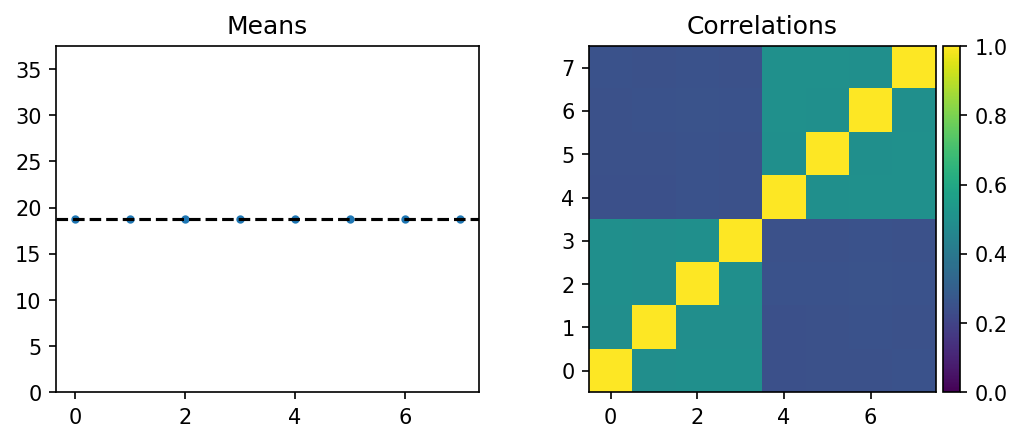

In [5]:
fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150)

axs[0].plot(np.mean(samps,axis=1),'.')
axs[0].set_ylim([0,2*l])
axs[0].axhline(l,color='k',linestyle='--')
pf.imshowbar(fig,axs[1],np.corrcoef(samps),hide_ticks=False,vmin=0,vmax=1,cmap='viridis',origin='lower')

axs[0].set_title('Means')
axs[1].set_title('Correlations')

## Generate Correlated Spike Counts

We'll model firing rates as $r(t) = r_b + (r_m - r_b) \exp\left[\left(-\frac{t}{t_d/2}\right)^{n_b}\right]$ for $t \in [-t_i/2,t_i/2]$ with $r_b = 2\text{Hz}$ and $r_m = 25\text{ Hz}$ (Note that this is much less than the $75$ Hz rate seen in Weliky & Katz). We'll vary the burst duration $t_d$, the interburst interval $t_i$, and the sharpness of the rate dynamics (parameterized by $n_b$) as necessary. We'll use a $\Delta t = 250\text{ ms}$ counting time window, with spike count expectation within each bin equal to $\lambda(t) = r(t)\Delta t$

The identical firing rate dynamics will induce increased correlations in the spike counts. Denote the spike counts for two cells in trial $i$ at time $t$ as $x_i(t)$ and $y_i(t)$ such that $\text{E}_i[x_i(t)] = \text{E}_i[y_i(t)] = \lambda(t)$ and $\text{Corr}_i[x_i(t),y_i(t)] = \rho$. We can show that the correlation of the two spike trains across trials and time, which we denote as $\overline{\rho}$, is given by

$$\overline{\rho} = \frac{\overline{\lambda(t)} \left(\rho - \overline{\lambda(t)}\right) + \overline{\lambda(t)^2}}{\overline{\lambda(t)} \left(1 - \overline{\lambda(t)}\right) + \overline{\lambda(t)^2}}$$
$$\rho = \overline{\rho} + \left(\overline{\rho} - 1\right)\frac{\overline{\lambda(t)^2} - \left(\overline{\lambda(t)}\right)^2}{\overline{\lambda(t)}}$$

Note that for binary variables, the relationships are:

$$\overline{\rho} = \frac{\overline{p(t)^2} - \left(\overline{p(t)}\right)^2 + \left(\overline{p(t)} - \overline{p(t)^2}\right)\rho}{\overline{p(t)}\left(1-\overline{p(t)}\right)}$$
$$\rho = \frac{\left(\overline{p(t)}\right)^2 - \overline{p(t)^2} + \left(\overline{p(t)}\left(1-\overline{p(t)}\right)\right)\overline{\rho}}{\overline{p(t)} - \overline{p(t)^2}}$$

In [6]:
reload(bf)

rm = 10 # Hz
rb = 1 # Hz
dt = 0.25 # s
ibi = 26 # s
dur = 15 # s

ts = np.linspace(-ibi/2,ibi/2,int(np.round(ibi/dt))+1)[:-1]

rng = np.random.default_rng(0)

l_t = ((rm-rb)*np.exp(-np.abs(ts/(0.5*dur))**2.4) + rb) * dt

El = np.mean(l_t)
El2 = np.mean(l_t**2)

nsamp = 1000
spikes = np.zeros((len(ts),8,nsamp))

rs_ideal = 0.5
ro_ideal = 0.25
rs = rs_ideal + (rs_ideal - 1)*(El2/El - El)
ro = ro_ideal + (ro_ideal - 1)*(El2/El - El)
r = np.block([[rs*np.ones((4,4)),ro*np.ones((4,4))],
              [ro*np.ones((4,4)),rs*np.ones((4,4))]])

print(rs,ro)

for idx,l in enumerate(l_t):
    spikes[idx] = bf.gen_corr_pois_vars(l*np.ones(8),r,rng,nsamp)

0.275191674504485 -0.08721248824327249


Text(0.5, 1.0, 'Spike Train Correlations')

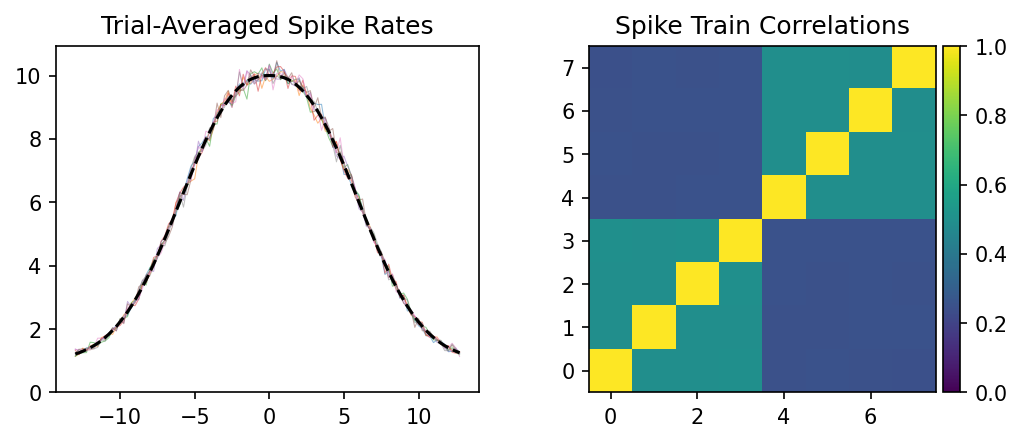

In [7]:
fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150)

axs[0].plot(ts,np.mean(spikes/dt,axis=-1),lw=0.5,alpha=0.5)
axs[0].plot(ts,l_t/dt,color='k',linestyle='--')
axs[0].set_ylim(0,None)
pf.imshowbar(fig,axs[1],np.corrcoef(spikes.transpose(1,0,2).reshape(8,-1)),hide_ticks=False,
             vmin=0,vmax=1,cmap='viridis',origin='lower')

axs[0].set_title('Trial-Averaged Spike Rates')
axs[1].set_title('Spike Train Correlations')

# Model Thalamic Waves Traveling Across Periodic Box

We'll model thalamic waves as moving bars sweeping across the periodic 2D box. The burst initiation times at a retinotopic location will coincide with the times that a bar moves across that site (or equivalently wrt a change of time coordinates we can choose the peak burst time to coincide with the time the bar crosses over that site). We can then generate a set of spiking probabilities across the entire grid at all times.

First, we'll investigate the assumption that ON/OFF-center cells have global binary spike correlations for a given time window. If necessary, we can consider spatial-distance dependent correlations. The goal is to match the same qualitative monotonic decrease in correlations with distance, as reported in Ohshiro & Weliky 2006.

## Generate Points in Periodic Box Passed by Moving Line

Given a bar with initial center point and length and a moving direction and distance (all assumed to be in normalized coordinates wrt to the box) we first want to compute the set of points mapped from a coordinate $s \in [0,1]$ parallel to the line and a coordinate $t \in [0,1]$ in the direction of the line's movement to coordinates $x,y \in [0,1]$ in the box. We can show that this relationship is given by the linear equation

$$\begin{pmatrix}x\\y\end{pmatrix} = \begin{pmatrix}x_0\\y_0\end{pmatrix} + \begin{pmatrix}\cos(\theta)\\\sin(\theta)\end{pmatrix} d t + \begin{pmatrix}-\sin(\theta)\\\cos(\theta)\end{pmatrix} l \left(\frac{1}{2} - s\right)$$

where $x_0,y_0$ are the initial bar center point, $l$ is the bar length, $\theta$ is the movement direction, and $d$ is the movement distance.

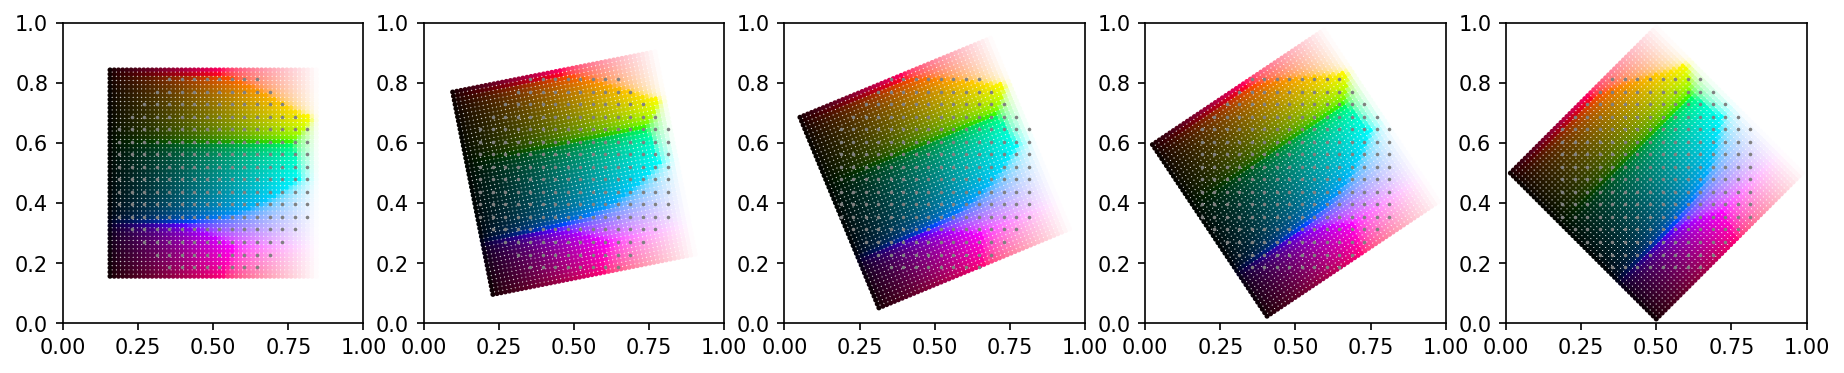

In [54]:
reload(bf)

nbar = 50
ngrid = 24
bar_len = 0.99/np.sqrt(2)

fig,axs = plt.subplots(1,5,figsize=(15,3),dpi=150)

ss,ts = np.meshgrid(np.linspace(0.5/nbar,1-0.5/nbar,nbar),np.linspace(0.5/nbar,1-0.5/nbar,nbar))
ss,ts = ss.flatten(),ts.flatten()
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()

in_rf = np.sqrt((xs-0.5)**2 + (ys-0.5)**2) < 0.5/np.sqrt(2)

# colors = mpl.colormaps['viridis'](ts.flatten())
# colors[:,3] = ss.flatten()
colors = pf.hsluv_to_rgb_vec(ss,np.ones_like(ss),ts)

for idx,ori in enumerate([0,np.pi/16,np.pi/8,3*np.pi/16,np.pi/4]):
    bar_to_box = bf.gen_mov_bar(0.5*(np.ones(2) - bar_len*np.array([np.cos(ori),np.sin(ori)])),
                             ori,bar_len,bar_len)
    bar_pos = bar_to_box(ss,ts)
    axs[idx].scatter(bar_pos[:,0],bar_pos[:,1],s=2,c=colors)
    axs[idx].scatter(xs[in_rf],ys[in_rf],s=0.5,c='gray')

    axs[idx].set_xlim([0,1])
    axs[idx].set_ylim([0,1])
    axs[idx].set_aspect('equal')

## Determine if Point in Box Contained within Sweep Area

We now want to determine whether or not a given coordinate $x,y \in [0,1]$ in the box is contained in the area sweeped by the moving line. We'll do this by seeing if a box point is near one of the points generated from the moving line sweep.

In [9]:
def in_bar_sweep(
    bar_poss: np.ndarray,
    box_poss: np.ndarray,
    res: float=1e-3,
    ):
    dists = np.sqrt(np.sum((bar_poss[...,None,:,:]-box_poss[...,:,None,:])**2,axis=-1))
    return np.any(dists <= res,axis=-1)

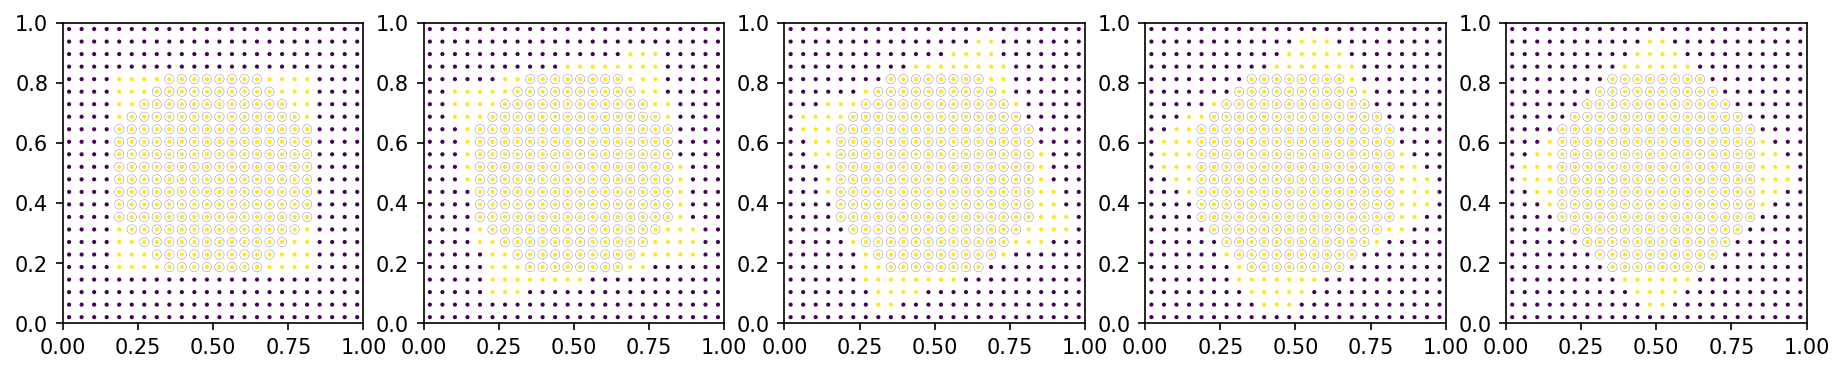

In [10]:
reload(bf)

nbar = 50
bar_len = 0.99/np.sqrt(2)
res = 1.001*bar_len/nbar/np.sqrt(2)
ngrid = 24

fig,axs = plt.subplots(1,5,figsize=(15,3),dpi=150)

ss,ts = np.meshgrid(np.linspace(0.5/nbar,1-0.5/nbar,nbar),np.linspace(0.5/nbar,1-0.5/nbar,nbar))
ss,ts = ss.flatten(),ts.flatten()
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()

in_rf = np.sqrt((xs-0.5)**2 + (ys-0.5)**2) < 0.5/np.sqrt(2)

for idx,ori in enumerate([0,np.pi/16,np.pi/8,3*np.pi/16,np.pi/4]):
    bar_to_box = bf.gen_mov_bar(0.5*(np.ones(2) - bar_len*np.array([np.cos(ori),np.sin(ori)])),
                             ori,bar_len,bar_len)
    bar_pos = bar_to_box(ss,ts)
    colors = mpl.colormaps['viridis'](in_bar_sweep(bar_pos,np.array([xs.flatten(),ys.flatten()]).T,res).astype(float))
    axs[idx].scatter(xs,ys,s=1,c=colors)
    axs[idx].scatter(xs[in_rf],ys[in_rf],marker='o',s=20,edgecolors='gray',facecolors='none',lw=0.2)

    axs[idx].set_xlim([0,1])
    axs[idx].set_ylim([0,1])
    axs[idx].set_aspect('equal')

## Compute Time when Moving Line Passes Points

Now we want to compute if a given coordinate $x,y \in [0,1]$ is contained in the area sweeped by the moving line, then what coordinates $s,t \in [0,1]$ in the moving line coordinates it corresponds to. $t$ can then be used to determine the exact burst initiation (or peak) time, which can be used to generate the spike probabilities.

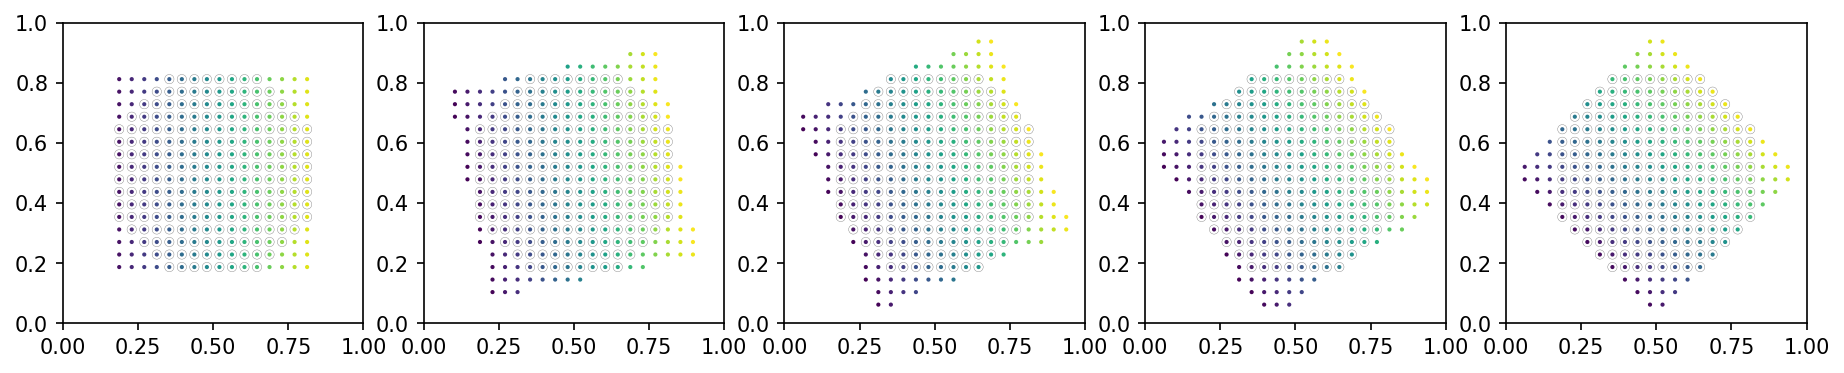

In [11]:
reload(bf)

nbar = 50
bar_len = 0.99/np.sqrt(2)
res = 1.001*bar_len/nbar/np.sqrt(2)
ngrid = 24

fig,axs = plt.subplots(1,5,figsize=(15,3),dpi=150)

ss,ts = np.meshgrid(np.linspace(0.5/nbar,1-0.5/nbar,nbar),np.linspace(0.5/nbar,1-0.5/nbar,nbar))
ss,ts = ss.flatten(),ts.flatten()
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()

in_rf = np.sqrt((xs-0.5)**2 + (ys-0.5)**2) < 0.5/np.sqrt(2)

for idx,ori in enumerate([0,np.pi/16,np.pi/8,3*np.pi/16,np.pi/4]):
    bar_to_box = bf.gen_mov_bar(0.5*(np.ones(2) - bar_len*np.array([np.cos(ori),np.sin(ori)])),
                             ori,bar_len,bar_len)
    bar_pos = bar_to_box(ss,ts)
    colors = mpl.colormaps['viridis'](bf.bar_pass_time(bar_pos,np.array([xs,ys]).T,ts,res).astype(float))
    axs[idx].scatter(xs,ys,s=1,c=colors)
    axs[idx].scatter(xs[in_rf],ys[in_rf],marker='o',s=20,edgecolors='gray',facecolors='none',lw=0.2)

    axs[idx].set_xlim([0,1])
    axs[idx].set_ylim([0,1])
    axs[idx].set_aspect('equal')

# Model Thalamic Bursts Due to Traveling Waves

In our initial experiment, we'll consider a 16x16 circle of points and generate traveling waves every interburst interval as traveling from one edge of the circle to the opposite edge. Each traveling wave will add a generalized Gaussian envelope centered around that burst peak time to the firing rate dynamics

## Generate Burst Peak Times of Random Traveling Waves

In [28]:
reload(bf)

nwaves = 5
nbar = 40
ngrid = 20
bar_len = 0.99/np.sqrt(2)
res = 1.001*bar_len/nbar/np.sqrt(2)

ss,ts = np.meshgrid(np.linspace(0.5/nbar,1-0.5/nbar,nbar),np.linspace(0.5/nbar,1-0.5/nbar,nbar))
ss,ts = ss.flatten(),ts.flatten()
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()

in_rf = np.sqrt((xs-0.5)**2 + (ys-0.5)**2) < 0.5/np.sqrt(2)
xs,ys = xs[in_rf],ys[in_rf]
n_in_rf = len(xs)

rng = np.random.default_rng(0)

oris = rng.uniform(0,2*np.pi,nwaves)

pass_times = np.zeros((nwaves,n_in_rf))

for idx,ori in enumerate(oris):
    bar_to_box = bf.gen_mov_bar(0.5*(np.ones(2) - bar_len*np.array([np.cos(ori),np.sin(ori)])),
                             ori,bar_len,bar_len)
    bar_pos = bar_to_box(ss,ts)
    pass_times[idx] = bf.bar_pass_time(bar_pos,np.array([xs,ys]).T,ts,res)

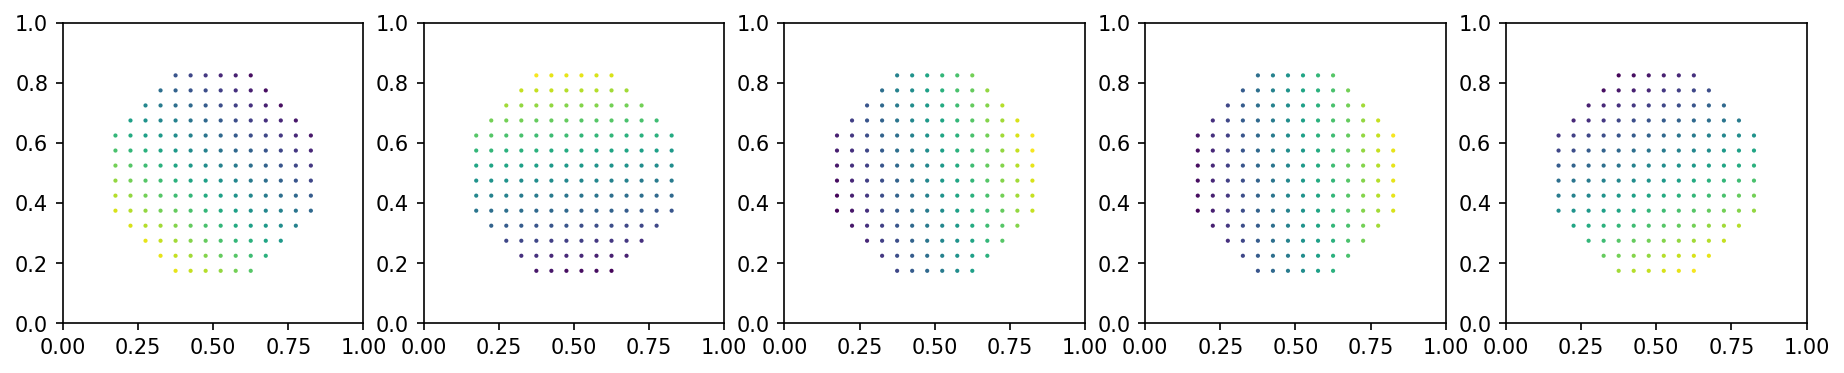

In [29]:
fig,axs = plt.subplots(1,5,figsize=(15,3),dpi=150)

for idx in range(5):
    colors = mpl.colormaps['viridis'](pass_times[idx])
    axs[idx].scatter(xs,ys,s=1,c=colors)

    axs[idx].set_xlim([0,1])
    axs[idx].set_ylim([0,1])
    axs[idx].set_aspect('equal')

## Generate Spike Counts due to Traveling Waves

In [36]:
rm = 10 # Hz
rb = 1 # Hz
dt = 0.25 # s
ibi = 26 # s
dur = 15 # s

burst_times = ibi*(0.25+0.5*pass_times + np.arange(nwaves)[:,None])

ts = np.linspace(0,ibi*nwaves,int(np.round(ibi*nwaves/dt))+1)

spike_ls = np.zeros((len(ts),n_in_rf))
spike_ls += rb * dt

for widx in range(nwaves):
    for cidx in range(n_in_rf):
        spike_ls[:,cidx] += (rm-rb)*np.exp(-(np.abs(ts-burst_times[widx,cidx])/(0.5*dur))**2.4) * dt
spike_ls = np.concatenate([spike_ls,spike_ls],-1)
spike_ls = np.fmax(1e-5,spike_ls)

In [37]:
dists = np.sqrt((xs[:,None]-xs[None,:])**2 + (ys[:,None]-ys[None,:])**2)
dist_corrs = np.exp(-0.5*(dists/0.5)**2)

rs = 0.35
ro = -0.35#0.05

spike_rs = np.block([[rs*dist_corrs,ro*dist_corrs],
                     [ro*dist_corrs,rs*dist_corrs]])
np.fill_diagonal(spike_rs,1)
spike_rs = spike_rs[None,:,:] * np.ones((len(ts),1,1))

us = np.linspace(0,1,501)[1:-1]
ns = np.zeros((len(us),2*n_in_rf))

for idx,l in tqdm(enumerate(spike_ls)):
    ns[:] = poisson.ppf(us[:,None],l[None,:])
    ns[:] = zscore(ns,axis=0)

    # lo_bnd = np.einsum('ijk,ijl->jkl',ns,ns[::-1,:,:]) / len(us)
    # up_bnd = np.einsum('ijk,ijl->jkl',ns,ns) / len(us)
    lo_bnd = ns.T@ns[::-1,:] / len(us)
    up_bnd = ns.T@ns / len(us)

    spike_rs[idx] = np.fmax(np.fmin(spike_rs[idx],up_bnd),lo_bnd)
    np.fill_diagonal(spike_rs[idx],1)

521it [01:35,  5.46it/s]


In [38]:
reload(bf)

rng = np.random.default_rng(0)

spikes = np.zeros((len(ts),2*n_in_rf),np.ushort)

for idx,l,r in tqdm(zip(range(len(ts)),spike_ls,spike_rs)):
    spikes[idx] = bf.gen_corr_pois_vars(l,r,rng)[:,0]

521it [04:21,  1.99it/s]


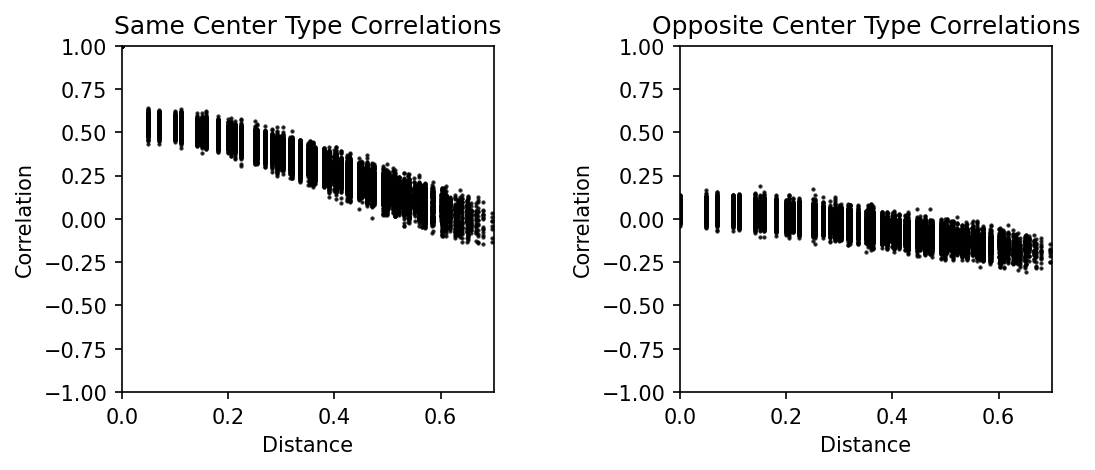

In [39]:
dists = np.sqrt((xs[:,None]-xs[None,:])**2 + (ys[:,None]-ys[None,:])**2)
corrs = np.corrcoef(spikes.T)

fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150)
fig.subplots_adjust(wspace=0.5)

axs[0].scatter(dists,corrs[:n_in_rf,:n_in_rf],s=1,color='k',alpha=0.5)
axs[0].scatter(dists,corrs[n_in_rf:,n_in_rf:],s=1,color='k',alpha=0.5)

axs[1].scatter(dists,corrs[:n_in_rf,n_in_rf:],s=1,color='k',alpha=0.5)
axs[1].scatter(dists,corrs[n_in_rf:,:n_in_rf],s=1,color='k',alpha=0.5)

axs[0].set_title('Same Center Type Correlations')
axs[1].set_title('Opposite Center Type Correlations')

for idx in range(2):
    axs[idx].set_xlabel('Distance')
    axs[idx].set_ylabel('Correlation')
    
    axs[idx].set_xlim(0,bar_len)
    axs[idx].set_ylim(-1,1)

In [40]:
print(np.mean(corrs[:n_in_rf,:n_in_rf][np.logical_and(0 < dists,dists < 0.1)]))
print(np.mean(corrs[:n_in_rf,n_in_rf:][dists < 0.1]))

0.5376091604536385
0.045417335807971006


# Check Spike Counts from Cluster Runs

In [41]:
import pickle

with open('./../results/lgn_wave_spikes_nw={:d}_ng={:d}/seed={:d}.pkl'.format(20,20,0), 'rb') as handle:
    res_dict = pickle.load(handle)

In [15]:
print(np.max(res_dict['spikes']))
print(np.mean(res_dict['spikes']))
print(np.std(res_dict['spikes']))

13
2.143870365578679
1.6661327179545795


In [18]:
res_dict['spikes'].shape

(2081, 312)

: 

In [17]:
%matplotlib Tk

from matplotlib.animation import FuncAnimation

fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
sc_n = axs[0].scatter(xs,ys,s=5,cmap='viridis',norm=mpl.colors.Normalize(vmin=0,vmax=5),c=np.zeros(n_in_rf))
sc_f = axs[1].scatter(xs,ys,s=5,cmap='viridis',norm=mpl.colors.Normalize(vmin=0,vmax=5),c=np.zeros(n_in_rf))

def init():
    for i in range(2):
        axs[i].set_xlim(0,1)
        axs[i].set_ylim(0,1)
        axs[i].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
        axs[i].set_aspect('equal')
    return sc_n,sc_f,

def update(frame):
    sc_n.set_array(np.mean(res_dict['spikes'][4*frame:4*frame+4,:n_in_rf],0))
    sc_f.set_array(np.mean(res_dict['spikes'][4*frame:4*frame+4,n_in_rf:],0))
    return sc_n,sc_f,

ani = FuncAnimation(fig, update, frames=len(res_dict['spikes']//4),
                    init_func=init, blit=True, interval=10, repeat_delay=10, repeat=True)
# plt.show()

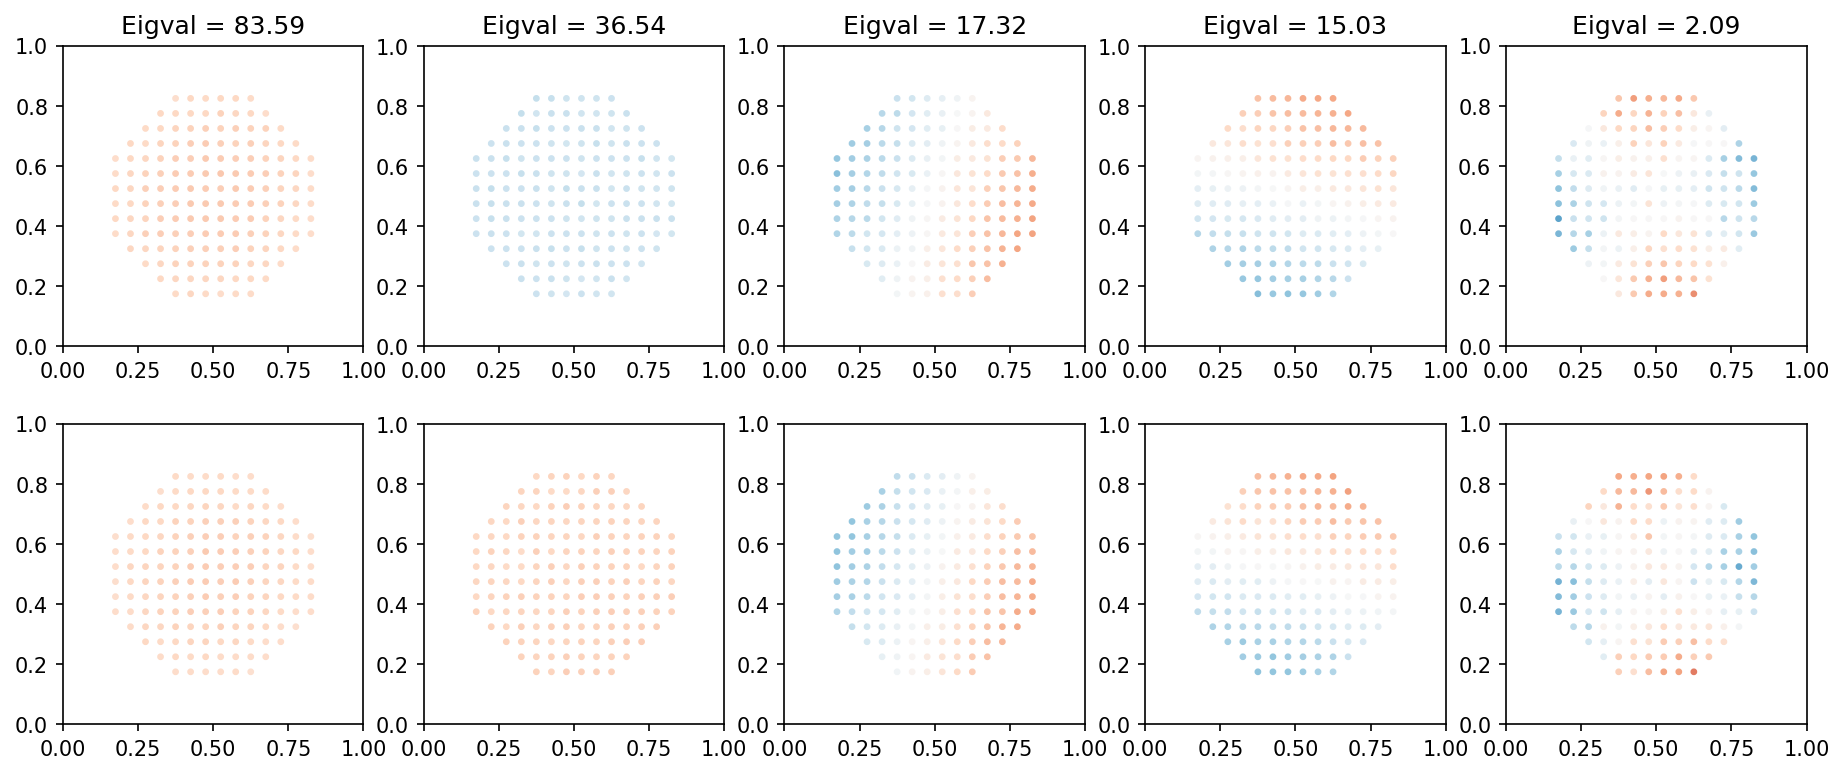

In [42]:
corrs = np.corrcoef(res_dict['spikes'].T)
vals,vecs = np.linalg.eigh(corrs)

fig,axs = plt.subplots(2,5,figsize=(15,6),dpi=150)

for idx in range(5):
    max_vec_val = np.max(np.abs(vecs))
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[:n_in_rf,-(idx+1)]/max_vec_val)
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[n_in_rf:,-(idx+1)]/max_vec_val)
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')
        
    axs[0,idx].set_title('Eigval = {:.2f}'.format(vals[-(idx+1)]))